In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
import pandas as pd
import matplotlib.ticker as ticker
import scipy as sp
import assortment_functions as af # this is the assortment_functions.py file
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
from collections import Counter
# from numba import njit, prange

### This may produce warning signs (comment out if needed)
font = {        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)
# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})

import scipy.io
mat = sp.io.loadmat('dynamic_parameters.mat')
par_dist = np.zeros((3,2,11))
par_dist[0,0,:] = mat['Win1'].reshape(12)[:-1]
par_dist[0,1,:] = mat['Win2'].reshape(12)[:-1]

par_dist[1,0,:] = mat['Deadlock1'].reshape(12)[:-1]
par_dist[1,1,:] = mat['Deadlock2'].reshape(12)[:-1]

par_dist[2,0,:] = mat['Lose1'].reshape(12)[:-1]
par_dist[2,1,:] = mat['Lose2'].reshape(12)[:-1]

def poll_fraction(g,n):
    party = g.nodes[n]['party']
    delta = 1 # Since the node knows it will vote for its own party
    neighbours = list(g.neighbors(n))
    for m in neighbours:
        if g.nodes[m]['party'] == party:
            delta+=1
    delta = delta/(len(neighbours)+1)
    return delta

def dynamics(g,last=False,ass=False,late=False,full_ig=False,par_mean=False):
    V = 0.6 # Super-majority
    
    T = 240 # Total length of game in seconds
    t_decision = 3.3 # The time between updates
    t = 0
    
    t_transition = 83 # Transition between early and late
    no_decisions = int(T//t_decision) # No of updates
    
    polls = np.array([poll_fraction(g,n) for n in g]) # 
    initial_parties = np.array(list(nx.get_node_attributes(g,'party').values()))
    intentions = np.zeros((no_decisions+1,len(g)))
    intentions[0,:] = initial_parties
    
    if full_ig:
        IG = np.zeros(no_decisions+1)
        IG[0] = af.influence_gap(g,absolute=False)
    
    if ass:
        assortment = np.zeros((no_decisions+1,2))
        assortment[0,:] = list(af.party_assortment(g).values())
    
    rand_numbers = np.random.rand(no_decisions+1,len(g))
    
    pars = np.zeros((3,2,len(g)))
    for i in range(3):
        for j in range(2):
            if not par_mean:
                pars[i,j,:] = np.random.choice(np.linspace(0,1,11),p=par_dist[i,j,:],size=len(g))
            else:
                pars[i,j,:] = mean_prob[i,j]
    
    phase = 0 # Early
    for t_index in range(1,no_decisions+1):
        t += t_decision
#         t_index = int(t//t_decision)
        if t > 83:
            phase = 1 # Late
            if late & (t<83+3.3):
                IG = af.influence_gap(g,absolute=False)
        pars_now = np.zeros(len(g))
        pars_now[polls>=V] = pars[0,phase,polls>=V]
        pars_now[(polls>=1-V)&(polls<V)] = pars[1,phase,(polls>=1-V)&(polls<V)]
        pars_now[polls<1-V] = pars[2,phase,polls<1-V]
        
        if full_ig:
            IG[t_index] = af.influence_gap(g,absolute=False)
        
        for n in g:
            if rand_numbers[t_index,n] <= pars_now[n]:
                intentions[t_index,n] = int(initial_parties[n])
            else:
                intentions[t_index,n] = int(1 - initial_parties[n])
        parties_dict = {n:int(intentions[t_index,n]) for n in g}
        nx.set_node_attributes(g,parties_dict,'party')
        # CORRECTION LINE 27/5/21
        polls = np.array([poll_fraction(g,n) for n in g])
        # END OF CORRECTION 27/5/21
        if ass:
            assortment[t_index,:]=list(af.party_assortment(g).values())
#         print(t_index)
#         print(initial_parties)
    if last:
        return intentions[-1,:]
    elif late:
        return IG,np.sum(intentions[-1,:])/len(g)-0.5
    elif ass:
        return assortment
    elif full_ig:
        return IG,np.sum(intentions,axis=1)/len(g) - 0.5
    else:
        return intentions
    
def dVS_gap(g,step=1):
    DG = np.zeros(len(g))
    parties = nx.get_node_attributes(g,'party')
    for n in g:
        poll_n = poll_fraction(g,n)
        if poll_n>=1/2:
            DG[n] = parties[n]
        else:
            DG[n] = 1-parties[n]
    if step <= 1:
        return np.sum(DG)/len(g) - 0.5
    else:
        h = g.copy()
        nx.set_node_attributes(h,{n:DG[n] for n in h},'party')
        return dVS_gap(h,step=step-1)
    
def wasted_vote(g,n):
    party = g.nodes[n]['party']
    neighbours = list(g.neighbors(n))
    frac = poll_fraction(g,n)
    if frac >= 1/2:
        A = 1
        B = 0
        for neigh in neighbours:
            if g.nodes[neigh]['party'] == party:
                A+=1
            else:
                B+=1
        return int(np.ceil((A-B)/2)-1)
    else:
        friends = 1
        for neigh in neighbours:
            if g.nodes[neigh]['party'] == party:
                friends += 1
        return friends

def efficiency_gap(g):
    wasted_votes = np.array([wasted_vote(g,n) for n in g])
    red_wv = [wasted_votes[n] for n in g if g.nodes[n]['party'] == 1]
    blu_wv = [wasted_votes[n] for n in g if g.nodes[n]['party'] == 0]
    return np.sum(red_wv) - np.sum(blu_wv)

In [4]:
h = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
p = [0,0.4,1]
N=20
per_maj = 30

no_voters_0 = [i for i in range(1,20) for j in range(1,20-i)] 
no_voters_1 = [j for i in range(1,20) for j in range(1,20-i)]
no_voters_2 = [20 - no_voters_0[i] - no_voters_1[i] for i in range(len(no_voters_0))]
no_voters = np.array([no_voters_0*per_maj, no_voters_1*per_maj, no_voters_2*per_maj]).transpose()
mult_of_maj = len(no_voters_0)

samples = per_maj*mult_of_maj

IG = np.zeros((per_maj*mult_of_maj,3))
outcomes = np.zeros((per_maj*mult_of_maj,3))
# dVS = np.zeros(samples*10)
# EG = np.zeros(samples*10)
dfs=[]
for k in range(3):
    for j in trange(11):
        for i in range(per_maj*mult_of_maj):
#             node_list = np.random.choice(range(N),size=(N//2+Majority[i]),replace=False)
#             parties = {n:int(n in node_list) for n in range(N)} 
            party_0 = np.random.choice(range(N),size=no_voters[i,0],replace=False)
            party_1 = np.random.choice([n for n in range(N) if n not in party_0],
                                       size=no_voters[i,1],replace=False)
            party_2 = [n for n in range(N) if n not in party_0 and n not in party_1]
            parties = {**{n:0 for n in party_0}, **{n:1 for n in party_1}, **{n:2 for n in party_2}}
            G = af.homophilic_relaxed_caveman_graph(2,10,p[k],h[j],parties)
            IG[i,:] = [af.influence_gap(G,p=n) for n in range(3)]
            
            # running the election
            election_outcome = Counter(af.dynamics(G,last=True))
            outcomes[i,:] = [election_outcome[p] for p in range(3)]
            
        df = pd.DataFrame(data=np.concatenate((no_voters,IG,outcomes,
                                               np.array([h[j]]*per_maj*mult_of_maj).reshape(per_maj*mult_of_maj,1),
                                               np.array([p[k]]*per_maj*mult_of_maj).reshape(per_maj*mult_of_maj,1)
                                              ),axis=1),
                          columns=['Party_0_initial','Party_1_initial','Party_2_initial',
                                   'IG_0','IG_1','IG_2',
                                   'Party_0_final','Party_1_final','Party_2_final',
                                   'Homophily','Rewire'])
        dfs.append(df)
#         df.to_csv('Dynamics/Corrections 27-5-21/hRC_h{0}p{1}.csv'.format(h[j],p[k]),index=False)
pd.concat(dfs).to_csv('Dynamics/Corrections 27-5-21/Multiparty/hRC_all_samples{0}a.csv'.format(samples),
                       index=False)

100%|██████████| 11/11 [23:42<00:00, 129.30s/it]


In [4]:
no_vo_0 = np.array(no_voters_0)
len(no_vo_0[no_vo_0==1])

18

In [6]:
no_voters_0 = [i for i in range(1,20) for j in range(1,20-i)] 
no_voters_1 = [j for i in range(1,20) for j in range(1,20-i)]
no_voters_2 = [20 - no_voters_0[i] - no_voters_1[i] for i in range(len(no_voters_0))]

counter_0 = Counter(no_voters_0)
counter_1 = Counter(no_voters_1)
counter_2 = Counter(no_voters_2)

print('Red: ', counter_0)
print('Blu: ', counter_1)
print('Gre: ', counter_2)

Red:  Counter({1: 18, 2: 17, 3: 16, 4: 15, 5: 14, 6: 13, 7: 12, 8: 11, 9: 10, 10: 9, 11: 8, 12: 7, 13: 6, 14: 5, 15: 4, 16: 3, 17: 2, 18: 1})
Blu:  Counter({1: 18, 2: 17, 3: 16, 4: 15, 5: 14, 6: 13, 7: 12, 8: 11, 9: 10, 10: 9, 11: 8, 12: 7, 13: 6, 14: 5, 15: 4, 16: 3, 17: 2, 18: 1})
Gre:  Counter({1: 18, 2: 17, 3: 16, 4: 15, 5: 14, 6: 13, 7: 12, 8: 11, 9: 10, 10: 9, 11: 8, 12: 7, 13: 6, 14: 5, 15: 4, 16: 3, 17: 2, 18: 1})


In [11]:
samples=10
no_voters = np.array([no_voters_0*samples, no_voters_1*samples, no_voters_2*samples]).transpose()
# no_voters.shape

(1710, 3)

In [19]:
i=100
party_0 = np.random.choice(range(N),size=no_voters[i,0],replace=False)
party_1 = np.random.choice([n for n in range(N) if n not in party_0],
                                       size=no_voters[i,1],replace=False)
party_2 = [n for n in range(N) if n not in party_0 and n not in party_1]
party_list = {**{n:0 for n in party_0}, **{n:1 for n in party_1}, **{n:2 for n in party_2}}
print(Counter(party_list.values()))
print(no_voters[i,:])

Counter({1: 8, 0: 7, 2: 5})
[7 8 5]


In [8]:
party_list = {**{n:0 for n in party_0}, **{n:1 for n in party_1}, **{n:2 for n in party_2}}
G = af.homophilic_relaxed_caveman_graph(2,10,1,0.6,party_list)

In [10]:
IGs = [af.influence_gap(G,p=p) for p in range(3)]
print(IGs)

[-1.2771917896917897, 1.146503959003959, -1.146503959003959]


In [11]:
election_outcome = af.dynamics(G,last=True)
print(election_outcome)

[1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 0. 2. 2. 1. 2.]


In [27]:
print(int(N*(N+1)/2)*10)
print(no_voters.shape[0])
print(samples*mult_of_maj)

2100
1710
17100


In [97]:
node_list = [n for n in range(20)]
N=20
reduced_list = np.random.choice(range(20),size=5,replace=False)
redx_list = np.random.choice([n for n in range(N) if n not in reduced_list],size=5,replace=False)
rem_list = [n for n in range(N) if n not in reduced_list and n not in redx_list]
print(node_list)
print(reduced_list)
print(redx_list)
print(rem_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[12 15 16  5 18]
[19 13  3 14  4]
[0, 1, 2, 6, 7, 8, 9, 10, 11, 17]


In [ ]:
count = 0
for i in range(20):
    for j in range(20-i):
        count+=1
#         print(i+j)
print(count)

In [90]:
Maj_0 = [i for i in range(1,20) for j in range(1,20-i)] 
Maj_1 = [j for i in range(1,20) for j in range(1,20-i)]
Maj_2 = [20 - Maj_0[i] - Maj_1[i] for i in range(len(Maj_0))]

In [105]:
Maj = np.array([Maj_0,Maj_1,Maj_2]).transpose()
df = pd.DataFrame(data=Maj,columns=['0','1','2'])
df.head()

,0,1,2
0,1,1,18
1,1,2,17
2,1,3,16
3,1,4,15
4,1,5,14


# testing hrc in >2 parties

In [ ]:
no_of_parties=3
N=15
party_list = {n:np.random.randint(0,no_of_parties) for n in range(N)}
g = af.homophilic_relaxed_caveman_graph(5,N//5,0.5,1,party_list,iterations=100)
nx.draw(g,node_color=list(party_list.values()),pos=nx.spring_layout(g),with_labels=True)

In [ ]:
all_assortments = af.all_party_assortment(g)
print('parties: ', all_assortments)
node_assortments = {n:af.node_assortment(g,n) for n in g}
print('nodes: ', node_assortments)

In [ ]:
af.node_assortment(g,0)

# testing sbms

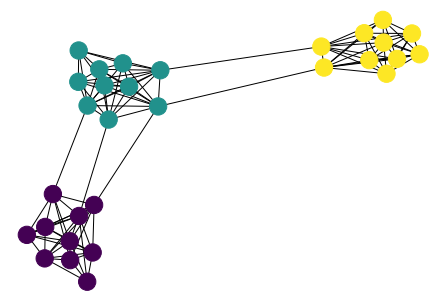

In [59]:
sizes = [10,10,10]
probs = [[0.8, 0.05,0.05],[0.05,0.8,0.05],[0.05,0.05,0.8]]
g = nx.stochastic_block_model(sizes,probs)
nx.draw(g,node_color=[0]*10+[1]*10+[2]*10)
num_to_party={0:'red',1:'blue',2:'green'}
nx.set_node_attributes(g,{i:i//10 for i in range(30)},'party')

In [57]:
print(nx.get_node_attributes(g,'party'))

{0: 'red', 1: 'red', 2: 'red', 3: 'red', 4: 'red', 5: 'red', 6: 'red', 7: 'red', 8: 'red', 9: 'red', 10: 'blue', 11: 'blue', 12: 'blue', 13: 'blue', 14: 'blue', 15: 'blue', 16: 'blue', 17: 'blue', 18: 'blue', 19: 'blue', 20: 'green', 21: 'green', 22: 'green', 23: 'green', 24: 'green', 25: 'green', 26: 'green', 27: 'green', 28: 'green', 29: 'green'}


In [60]:
print(af.dynamics(g,last=True))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.]


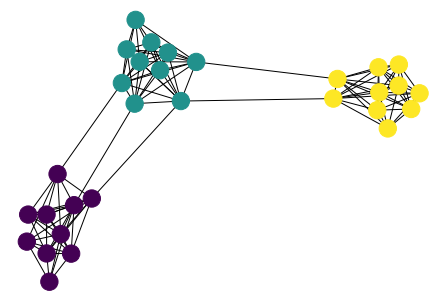

In [61]:
nx.draw(g,node_color=list(nx.get_node_attributes(g,'party').values()))

In [ ]:
poll = list(g.neighbors(0)) + [0]
poll_count = Counter([g.nodes[m]['party'] for m in poll])

In [ ]:
[g.nodes[m] for m in poll]

In [ ]:
x = {0:20,3:50,1:60}
max(x.values())